# Detectarea fețelor în imagini folosing o arhitectura cu regresie

Acest notebook demonstrează procesul de inferență utilizând modele deja antrenate. Rețelele utilizează un bloc convoluțional pentru extragerea caracteristicilor imaginilor și un component complet conectat pentru a produce o matrice de n x n x 5 valori, fiecare celulă a matricii având următoarele componente.

- probabilitatea ca celula curentă să conțină un obiect
- coordonata x a centrului casetei de detecție
- coordonata y a centrului casetei de detectie
- lătimea casetei de detecție
- înălțimea casetei de detectie

Modelele sunt mult prea mari pentru a fi încărcate interactiv, folosim posibilitatea de a monta google drive în mașina virtuală care execută codul

In [1]:
import google.colab
google.colab.drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [12]:
import sys
import os
import io
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from google.colab import files
from IPython.display import display
import gc
from torchvision.ops import nms

# Verificarea corectitudinii căilor

In [3]:
model_dir = '/content/gdrive/MyDrive/Facultate Informatica/Profesor/2024 - 2025/Biometrie/Curs/ColabMount/Models/Face/Elementary_regression'

In [4]:
if os.path.isdir(model_dir):
  print("Model directory exists")
else:
  print("Model directory does not exist")

Model directory exists


In [7]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Funcția de transformare

In [8]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Structura rețelei neuronale

In [9]:
class YOLOFaceCNN(nn.Module):
    def __init__(self, grid_size=7):
        super(YOLOFaceCNN, self).__init__()
        self.grid_size = grid_size

        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3), nn.LeakyReLU(0.1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 192, kernel_size=3, padding=1), nn.LeakyReLU(0.1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(192, 128, kernel_size=1), nn.LeakyReLU(0.1),
            nn.Conv2d(128, 256, kernel_size=3, padding=1), nn.LeakyReLU(0.1),
            nn.Conv2d(256, 256, kernel_size=1), nn.LeakyReLU(0.1),
            nn.Conv2d(256, 512, kernel_size=3, padding=1), nn.LeakyReLU(0.1),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 14 * 14, 4096),
            nn.BatchNorm1d(4096),
            nn.LeakyReLU(0.1),
            nn.Linear(4096, self.grid_size ** 2 * 5),  # Predicts (p, x, y, w, h) per grid cell
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x.view(-1, self.grid_size, self.grid_size, 5)  # Now predicts bounding boxes

In [ ]:
# Inferența

## Încărcarea imaginii

In [10]:
print("Incarcati o imagine de test")
uploaded_test_image = files.upload()  # Allows user to upload a file
# Get the first uploaded file
uploaded_test_image_path = list(uploaded_test_image.keys())[0]

Incarcati o imagine de test


Saving pexels-ivan-samkov-4625070.jpg to pexels-ivan-samkov-4625070.jpg


## Citirea și prelucrarea imaginii

Width: 720 Height: 1080


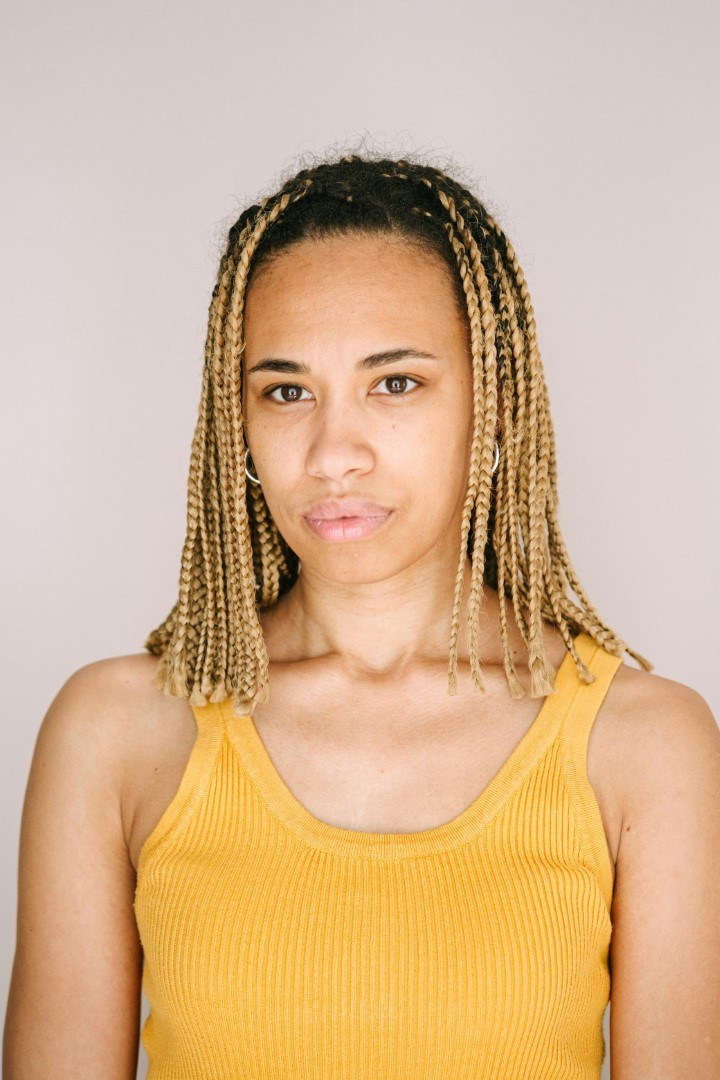

In [11]:
original_image = Image.open(uploaded_test_image_path).convert("RGB")
image_width, image_height = original_image.size
print(f"Width: {image_width} Height: {image_height}")
display(original_image)

transformed_image = transform(original_image).unsqueeze(0).to(DEVICE)

## Trecerea imaginii prim rețeaua neuronală

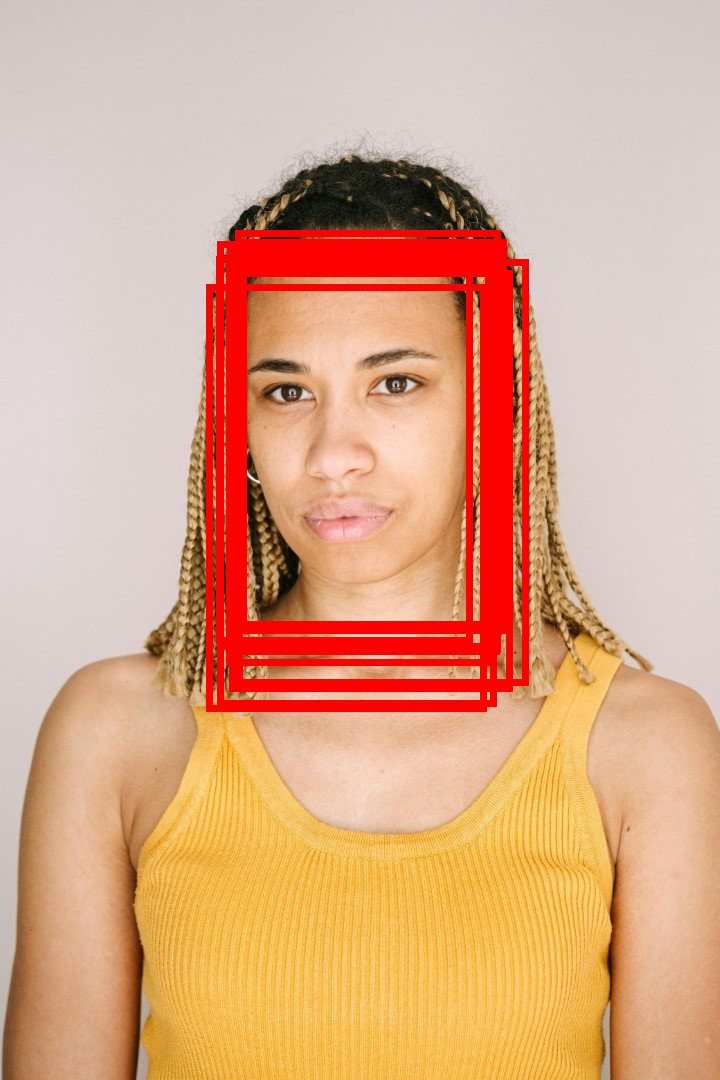

In [16]:
object_threshold = 0.7
nms_threshold = 0.5

model_file = os.path.join(model_dir, 'yolo_like_simple_loss.pth')
if os.path.isfile(model_file):
  model = YOLOFaceCNN(grid_size=7).to(DEVICE)
  model.load_state_dict(torch.load(model_file, map_location=torch.device('cpu'), weights_only=True))
  model.eval()
  with torch.no_grad():
    output = model(transformed_image)  # Shape: (1, 7, 7, 5)
    output = output.squeeze(0)  # Remove batch dim
    rows, cols, features = output.shape
    filtered_boxes = output[output[:, :, 0] > object_threshold]

    x_center = (filtered_boxes[:, 1] * image_width).cpu().numpy()
    y_center = (filtered_boxes[:, 2] * image_height).cpu().numpy()
    box_width = (filtered_boxes[:, 3] * image_width).cpu().numpy()
    box_height = (filtered_boxes[:, 4] * image_height).cpu().numpy()

    # Create bounding boxes in the form (x1, y1, x2, y2) for NMS
    x1 = x_center - box_width / 2
    y1 = y_center - box_height / 2
    x2 = x_center + box_width / 2
    y2 = y_center + box_height / 2

    boxes = torch.tensor(np.array([x1, y1, x2, y2])).T
    scores = filtered_boxes[:, 0].clone()

    image_copy = original_image.copy()
    draw = ImageDraw.Draw(image_copy)

    for i, box in enumerate(boxes):

        x1, y1, x2, y2 = box.tolist()
        outline_color = (255, 0, 0)  # Red for example, change it as needed
        draw.rectangle([x1, y1, x2, y2], outline=outline_color, width=7)
    display(image_copy)



## Aplicarea NMS pe casetele obținute

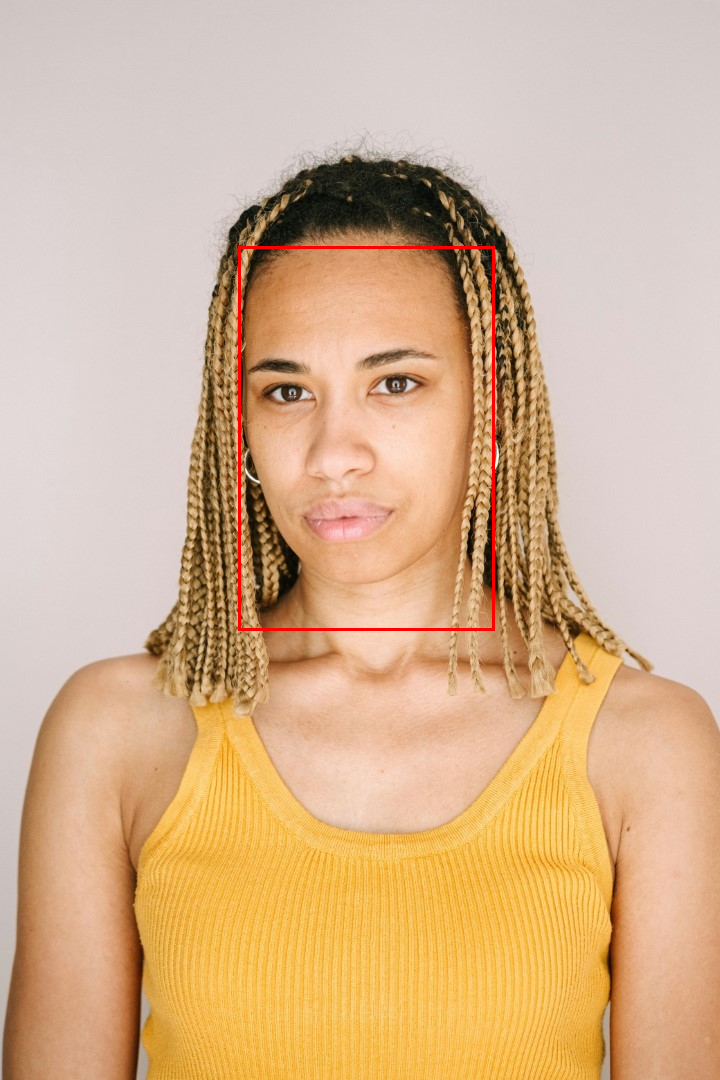

In [17]:
indices = nms(boxes, scores, iou_threshold=nms_threshold)
image_copy2 = original_image.copy()

draw = ImageDraw.Draw(image_copy2)

for idx in indices:
    box = boxes[idx].cpu().numpy()
    x1, y1, x2, y2 = map(int, box)
    draw.rectangle([x1, y1, x2, y2], outline="red", width=3)

display(image_copy2)